In [1]:
import rdkit

In [2]:
from rdkit import Chem

| Target | Property | Description                        | Unit    |
|--------|----------|------------------------------------|---------|
| 0      | mu       | Dipole moment                      | D       |
| 1      | alpha    | Isotropic polarizability           | (a_0)^3 |
| 2      | HOMO     | HOMO                               | eV      |
| 3      | LUMO     | LUMO                               | eV      |
| 4      | gap      | Gap between HOMO-LUMO              | eV      |
| 5      | r2       | Electronic spatial extent          | (a_0)^2 |
| 6      | ZPVE     | Zero point vibrational energy      | eV      |
| 7      | u0       | Internal energy at 0K              | eV      |
| 8      | u        | Internal energy at 298.15K         | eV      |
| 9      | h        | Enthalpy at 298.15K                | eV      |
| 10     | g        | Free energy at 298.15K             | eV      |
| 11     | cv       | Heat capacity at 298.15K           | mol K   |
| 12     | u0_atom  | Atomization energy at 0K           | eV      |
| 13     | u_atom   | Atomization energy at 298.15K      | eV      |
| 14     | h_atom   | Atomization enthalpy at 298.15K    | eV      |
| 15     | g_atom   | Atomization free energy at 298.15K | eV      |
| 16     | A        | Rotational constant                | GHz     |
| 17     | B        | Rotational constant                | GHz     |
| 18     | C        | Rotational constant                | GHz     |

### xyz file 하나 불러와서 각 속성 정보 따오는 코드

In [8]:
import numpy as np
import torch

def parse_float(s: str) -> float:
    try:
        return float(s)
    except ValueError:
        base, power = s.split('*^')
        return float(base) * 10**float(power)


def parse_xyz(filename):
    """
    Parses QM9 specific xyz files. See https://www.nature.com/articles/sdata201422/tables/2 for reference
    :param filename: str path to file
    :return:
    """
    num_atoms = 0
    scalar_properties = []
    atomic_symbols = []
    xyz = []
    charges = []
    harmonic_vibrational_frequencies = []
    smiles = ''
    inchi = ''
    with open(filename, 'r') as f:
        for line_num, line in enumerate(f):
            if line_num == 0:
                num_atoms = int(line)
            elif line_num == 1:
                scalar_properties = [float(i) for i in line.split()[2:]]
            elif 2 <= line_num <= 1 + num_atoms:
                atom_symbol, x, y, z, charge = line.split()
                atomic_symbols.append(atom_symbol)
                xyz.append([parse_float(x), parse_float(y), parse_float(z)])
                charges.append(parse_float(charge))
            elif line_num == num_atoms + 2:
                harmonic_vibrational_frequencies = [float(i) for i in line.split()]
            elif line_num == num_atoms + 3:
                smiles = line.split()[0]
            elif line_num == num_atoms + 4:
                inchi = line.split()[0]

    result = {
        'num_atoms': num_atoms,
        'atomic_symbols': atomic_symbols,
        'pos': torch.tensor(xyz),
        'charges': np.array(charges),
        'harmonic_oscillator_frequencies': harmonic_vibrational_frequencies,
        'smiles': smiles,
        'inchi': inchi
    }
    scalar_property_labels = ['A', 'B', 'C', 'mu', 'alpha', 'homo', 'lumo', 'gap', 'r2', 'zpve', 'u0', 'u', 'h', 'g', 'cv']
    scalar_properties = dict(zip(scalar_property_labels, scalar_properties))
    result.update(scalar_properties)
    return result

__파일 하나 테스트 해봄__

In [10]:
fname = 'dsgdb9nsd_000001.xyz'

In [11]:
test = parse_xyz(fname)

In [12]:
test

{'num_atoms': 5,
 'atomic_symbols': ['C', 'H', 'H', 'H', 'H'],
 'pos': tensor([[-1.2698e-02,  1.0858e+00,  8.0010e-03],
         [ 2.1504e-03, -6.0313e-03,  1.9761e-03],
         [ 1.0117e+00,  1.4638e+00,  2.7657e-04],
         [-5.4082e-01,  1.4475e+00, -8.7664e-01],
         [-5.2381e-01,  1.4379e+00,  9.0640e-01]]),
 'charges': array([-0.535689,  0.133921,  0.133922,  0.133923,  0.133923]),
 'harmonic_oscillator_frequencies': [1341.307,
  1341.3284,
  1341.365,
  1562.6731,
  1562.7453,
  3038.3205,
  3151.6034,
  3151.6788,
  3151.7078],
 'smiles': 'C',
 'inchi': 'InChI=1S/CH4/h1H4',
 'A': 157.7118,
 'B': 157.70997,
 'C': 157.70699,
 'mu': 0.0,
 'alpha': 13.21,
 'homo': -0.3877,
 'lumo': 0.1171,
 'gap': 0.5048,
 'r2': 35.3641,
 'zpve': 0.044749,
 'u0': -40.47893,
 'u': -40.476062,
 'h': -40.475117,
 'g': -40.498597,
 'cv': 6.469}

### 폴더 내의 모든 xyz 파일 불러와서 dataframe으로 저장하는 코드

In [13]:
import pandas as pd
import os

# Set the path to the folder containing the XYZ files
folder_path = './'

# Get the list of XYZ files in the folder
xyz_files = [file for file in os.listdir(folder_path) if file.endswith('.xyz')]

# Create an empty list to store the results
results = []

# Iterate over the XYZ files
for file in xyz_files:
    file_path = os.path.join(folder_path, file)
    
    # Call the parse_xyz function to extract the information from the file
    result = parse_xyz(file_path)
    
    # Append the result to the list of results
    results.append(result)

# Convert the list of results to a DataFrame
df = pd.DataFrame(results)

# Print the DataFrame
print(df)

        num_atoms                                     atomic_symbols  \
0              23  [C, C, C, C, C, C, C, C, O, H, H, H, H, H, H, ...   
1              18  [C, C, N, C, C, O, C, C, O, H, H, H, H, H, H, ...   
2              25  [C, C, C, O, C, C, C, C, C, H, H, H, H, H, H, ...   
3              15      [O, C, C, O, C, C, C, O, C, H, H, H, H, H, H]   
4              18  [N, C, O, C, C, C, C, O, C, H, H, H, H, H, H, ...   
...           ...                                                ...   
133880         17  [C, C, C, O, C, N, C, C, H, H, H, H, H, H, H, ...   
133881         14         [O, C, C, O, C, O, H, H, H, H, H, H, H, H]   
133882         18  [C, C, C, C, C, C, C, C, N, H, H, H, H, H, H, ...   
133883         18  [C, N, C, C, C, O, N, C, N, H, H, H, H, H, H, ...   
133884         22  [C, C, C, C, C, C, O, N, C, H, H, H, H, H, H, ...   

                                                      pos  \
0       [[tensor(-0.0051), tensor(1.4588), tensor(-0.4...   
1       [[ten

In [14]:
df.head(5)

,num_atoms,atomic_symbols,pos,charges,harmonic_oscillator_frequencies,smiles,inchi,A,B,C,...,homo,lumo,gap,r2,zpve,u0,u,h,g,cv
0,23,"[C, C, C, C, C, C, C, C, O, H, H, H, H, H, H, ...","[[tensor(-0.0051), tensor(1.4588), tensor(-0.4...","[-0.379761, -0.27778, 0.431848, -0.288567, -0....","[66.9522, 120.0611, 163.7679, 193.1266, 227.90...",CCC12CCC(C)C1O2,"InChI=1S/C8H14O/c1-3-8-5-4-6(2)7(8)9-8/h6-7H,3...",3.74323,1.06884,0.95108,...,-0.2497,0.0890,0.3387,1366.2183,0.205771,-388.306749,-388.297374,-388.296430,-388.340757,35.962
1,18,"[C, C, N, C, C, O, C, C, O, H, H, H, H, H, H, ...","[[tensor(0.0803), tensor(1.5585), tensor(-0.02...","[-0.408106, -0.060018, -0.300466, -0.213953, 0...","[58.2753, 171.1712, 218.769, 279.0711, 286.196...",CC1NCC2OC2C1=O,"InChI=1S/C6H9NO2/c1-3-5(8)6-4(9-6)2-7-3/h3-4,6...",2.47471,1.70917,1.17282,...,-0.2283,-0.0338,0.1945,1068.0549,0.148179,-439.080379,-439.072340,-439.071396,-439.113109,30.793
2,25,"[C, C, C, O, C, C, C, C, C, H, H, H, H, H, H, ...","[[tensor(-0.0096), tensor(1.5943), tensor(-0.2...","[-0.381135, -0.183739, 0.13924, -0.424479, -0....","[28.5567, 70.3194, 99.2164, 122.2862, 176.4237...",CCC(O)CC1CC1C,"InChI=1S/C8H16O/c1-3-8(9)5-7-4-6(7)2/h6-9H,3-5...",3.82795,0.70743,0.64572,...,-0.2514,0.0706,0.3220,1868.1448,0.226745,-389.486207,-389.474935,-389.473990,-389.523555,41.038
3,15,"[O, C, C, O, C, C, C, O, C, H, H, H, H, H, H]","[[tensor(-0.0469), tensor(1.3793), tensor(0.10...","[-0.473524, 0.393578, -0.076026, -0.252793, 0....","[179.447, 259.3227, 285.7826, 326.864, 419.814...",OC12C3OC3C3C1OC23,InChI=1S/C6H6O3/c7-6-3-1(4(6)9-3)2-5(6)8-2/h1-...,2.98661,2.03567,1.50302,...,-0.2363,0.0564,0.2927,850.8027,0.112226,-457.653164,-457.646643,-457.645699,-457.683748,26.709
4,18,"[N, C, O, C, C, C, C, O, C, H, H, H, H, H, H, ...","[[tensor(-0.1242), tensor(1.2912), tensor(0.26...","[-0.525277, 0.418191, -0.362221, -0.342799, 0....","[18.4787, 69.3435, 87.5709, 122.1768, 195.826,...",NC(=O)CC1CC2OC12,"InChI=1S/C6H9NO2/c7-5(8)2-3-1-4-6(3)9-4/h3-4,6...",4.07673,0.94691,0.86798,...,-0.2461,0.0328,0.2789,1338.7366,0.146610,-439.079843,-439.070770,-439.069826,-439.115743,32.478


### pandas DF csv로 저장하는 코드

In [15]:
import pandas as pd

# Assuming you have a DataFrame called df

# Convert the DataFrame to a CSV file
df.to_csv('QM9_allfeatures.csv', index=False)

In [4]:
import pandas as pd

In [6]:
pwd

'/home/sjang/Project/PDF-main'

In [7]:
# Read the CSV file into a DataFrame
df = pd.read_csv('./QM9/QM9_allfeatures.csv')

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 133885 entries, 0 to 133884
Data columns (total 22 columns):
 #   Column                           Non-Null Count   Dtype  
---  ------                           --------------   -----  
 0   num_atoms                        133885 non-null  int64  
 1   atomic_symbols                   133885 non-null  object 
 2   pos                              133885 non-null  object 
 3   charges                          133885 non-null  object 
 4   harmonic_oscillator_frequencies  133885 non-null  object 
 5   smiles                           133885 non-null  object 
 6   inchi                            133885 non-null  object 
 7   A                                133885 non-null  float64
 8   B                                133885 non-null  float64
 9   C                                133885 non-null  float64
 10  mu                               133885 non-null  float64
 11  alpha                            133885 non-null  float64
 12  ho

In [ ]:
for i in df['atomic_symbols']:
    for j in i

In [27]:
df.columns

Index(['num_atoms', 'atomic_symbols', 'pos', 'charges',
       'harmonic_oscillator_frequencies', 'smiles', 'inchi', 'A', 'B', 'C',
       'mu', 'alpha', 'homo', 'lumo', 'gap', 'r2', 'zpve', 'u0', 'u', 'h', 'g',
       'cv'],
      dtype='object')

### EC의 HOMO-LUMO 값 있는지 찾아보기
* SMILES of EC : O=C1OCCO1

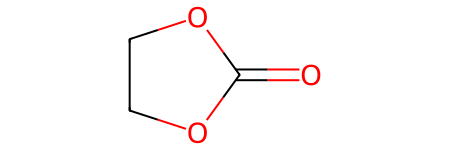

In [34]:
m = Chem.MolFromSmiles('O=C1OCCO1')
m

In [35]:
canonical = Chem.MolToSmiles(Chem.MolFromSmiles('O=C1OCCO1'))
canonical

'O=C1OCCO1'

In [32]:
df[df['smiles']=='O=C1OCCO1']

,num_atoms,atomic_symbols,pos,charges,harmonic_oscillator_frequencies,smiles,inchi,A,B,C,...,homo,lumo,gap,r2,zpve,u0,u,h,g,cv
111735,10,"['O', 'C', 'O', 'C', 'C', 'O', 'H', 'H', 'H', ...","tensor([[ 2.0074e-03, 4.2403e-03, 2.9593e-03...",[-0.366595 0.506779 -0.2382 -0.101347 -0.10...,"[135.214, 187.3974, 522.4235, 707.6737, 725.73...",O=C1OCCO1,InChI=1S/C3H4O3/c4-3-5-1-2-6-3/h1-2H2,8.03253,3.84232,2.70377,...,-0.2935,0.0401,0.3336,455.3293,0.074926,-342.352279,-342.34739,-342.346446,-342.380838,16.45


* HOMO of EC : -0.2935 eV
* LUMO of EC : 0.0401 eV

### TDC에서 Tox21 데이터 가져오기

In [37]:
from tdc.utils import retrieve_label_name_list
label_list = retrieve_label_name_list('Tox21')

In [39]:
from tdc.single_pred import Tox
data = Tox(name = 'Tox21', label_name = label_list[0])

Downloading...
100%|█████████████████████████████████████████████████████████████████████| 712k/712k [00:00<00:00, 862kiB/s]
Loading...
Done!


In [41]:
dir(data)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__len__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 'balanced',
 'binarize',
 'convert_format',
 'convert_from_log',
 'convert_result',
 'convert_to_log',
 'entity1',
 'entity1_idx',
 'entity1_name',
 'file_format',
 'get_data',
 'get_label_meaning',
 'get_split',
 'label_distribution',
 'label_name',
 'name',
 'path',
 'print_stats',
 'raw_format',
 'y']

In [42]:
split = data.get_split(method='random', frac=[0.7, 0.1, 0.2], seed=100)

In [44]:
train = split['train']
test = split['test']
val = split['valid']

In [45]:
train

,Drug_ID,Drug,Y
0,TOX3021,CCOc1ccc2nc(S(N)(=O)=O)sc2c1,0.0
1,TOX3020,CCN1C(=O)NC(c2ccccc2)C1=O,0.0
2,TOX3027,CCCN(CC)C(CC)C(=O)Nc1c(C)cccc1C,0.0
3,TOX20800,CC(O)(P(=O)(O)O)P(=O)(O)O,0.0
4,TOX6619,O=S(=O)(Cl)c1ccccc1,0.0
...,...,...,...
5081,TOX25183,Cc1ccc(=O)n(-c2ccccc2)c1,0.0
5082,TOX25180,NC(=O)CN1CC(O)CC1=O,0.0
5083,TOX25187,CCC(=O)c1ccc2c(c1)N(CCCN(C)C)c1ccccc1S2,0.0
5084,TOX25184,CCCNCC(O)COc1ccccc1C(=O)CCc1ccccc1,0.0


In [46]:
smi_list = list(train['Drug'])
len(smi_list)

5086

In [47]:
label_list = list(train['Y'])
len(label_list)

5086

In [49]:
smi = smi_list[0]
smi

'CCOc1ccc2nc(S(N)(=O)=O)sc2c1'

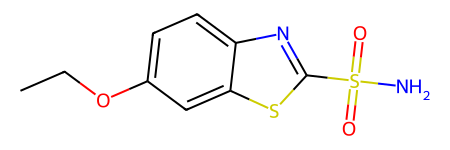

In [51]:
mol = Chem.MolFromSmiles(smi)
mol

In [55]:
atom_list = mol.GetAtoms()
atom_list
len(atom_list)

16

In [58]:
atom = atom_list[0]
print(atom.GetSymbol())
print(atom.GetDegree())
print(atom.GetTotalNumHs())
print(atom.GetImplicitValence())

C
1
3
3


In [61]:
bond_list = mol.GetBonds()
bond = bond_list[0]
print(bond.GetBeginAtom())
print(bond.GetBeginAtom().GetSymbol())
print(bond.GetBeginAtom().GetIdx())
print(bond.GetBondType())

print(bond.GetEndAtom())
print(bond.GetEndAtom().GetSymbol())
print(bond.GetEndAtom().GetIdx())

C
0
SINGLE
C
1


### TDC에서 ToxCast 데이터 가져오기

In [62]:
from tdc.utils import retrieve_label_name_list
label_list = retrieve_label_name_list('Toxcast')

In [63]:
from tdc.single_pred import Tox
data = Tox(name = 'ToxCast', label_name = label_list[0])
split = data.get_split(method='random', frac=[0.7, 0.1, 0.2], seed=100)

Downloading...
100%|██████████████████████████████████████████████████████████████████| 10.3M/10.3M [00:01<00:00, 5.82MiB/s]
Loading...
Done!


In [64]:
train_cast = split['train']

In [65]:
train_cast

,Drug_ID,Drug,Y
0,Drug 0,O=[N+]([O-])c1ccc(Cl)cc1,0.0
1,Drug 3,Nc1ccc([N+](=O)[O-])cc1,1.0
2,Drug 4,O=[N+]([O-])c1ccc(O)cc1,0.0
3,Drug 15,O=C(O)c1ccc(C(=O)O)cc1,0.0
4,Drug 22,Cl[Dy](Cl)Cl,0.0
...,...,...,...
1207,Drug 8551,CCOC(=O)O[C@H](C)OC(=O)c1ccc2c(c1)cc(C(=O)NC1C...,1.0
1208,Drug 8552,CCN(Cc1cccnc1)C(=O)c1cccc(Cl)c1[C@]1(C)C(=O)N(...,0.0
1209,Drug 8554,O=C([O-])c1ccc2c(c1)nc(C(=O)NC1CCN(C3CC3)CC1)n...,0.0
1210,Drug 8555,CC(=O)O.COCCOc1cc2cc(C(=O)NC3CCN(C(C)C)CC3)n(C...,0.0
